In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from tqdm import tqdm
import numpy as np

In [2]:
df_with_ah = pd.read_csv("https://amcneil36.github.io/programs/CountyStats/CountyStats.csv")

In [3]:
df_with_ah.head()

,County,County Population,Predominant City,State,People per sq mi,Median household income,% with at least Bachelor's degree,Median age,Median home price,Median home sqft,...,Percent of Summer days that include precipitation,Percent of Winter days that include precipitation,Annual snowfall (in),Days of snow per year,Average yearly windspeed (mph),Number of days with thunder per year,Air quality Index,UV Index,Latitude,Longitude
0,Kings (Brooklyn) County,11195193,New York,New York,30543,NaN,N/A%,NaN,$790000,1282.0,...,N/A%,N/A%,NaN,NaN,NaN,NaN,25,3,NaN,NaN
1,Los Angeles County,9844587,Los Angeles,California,8306,$77216,33%,37.0,$898540,1526.0,...,1%,18%,0.0,0.0,3.0,4.0,42,6,34.093762,-118.312738
2,Cook County,5962483,Chicago,Illinois,9912,$74417,41%,37.0,$340972,1522.0,...,36%,32%,41.0,27.0,8.0,38.0,51,3,41.850100,-87.765896
3,Maricopa County,4170303,Phoenix,Arizona,2896,$74634,34%,37.0,$476673,1746.0,...,10%,13%,0.0,0.0,6.0,25.0,52,6,33.509062,-112.039751
4,Orange County,3143253,Anaheim,California,6745,$101262,41%,38.0,$1052678,1690.0,...,1%,19%,0.0,0.0,5.0,4.0,53,5,33.731085,-117.862467


In [4]:
# Remove Alaska, HI to focus on continental US

df_uncleaned = df_with_ah[~df_with_ah["State"].isin(["Hawaii", "Alaska"])]

df_uncleaned.head()

,County,County Population,Predominant City,State,People per sq mi,Median household income,% with at least Bachelor's degree,Median age,Median home price,Median home sqft,...,Percent of Summer days that include precipitation,Percent of Winter days that include precipitation,Annual snowfall (in),Days of snow per year,Average yearly windspeed (mph),Number of days with thunder per year,Air quality Index,UV Index,Latitude,Longitude
0,Kings (Brooklyn) County,11195193,New York,New York,30543,NaN,N/A%,NaN,$790000,1282.0,...,N/A%,N/A%,NaN,NaN,NaN,NaN,25,3,NaN,NaN
1,Los Angeles County,9844587,Los Angeles,California,8306,$77216,33%,37.0,$898540,1526.0,...,1%,18%,0.0,0.0,3.0,4.0,42,6,34.093762,-118.312738
2,Cook County,5962483,Chicago,Illinois,9912,$74417,41%,37.0,$340972,1522.0,...,36%,32%,41.0,27.0,8.0,38.0,51,3,41.850100,-87.765896
3,Maricopa County,4170303,Phoenix,Arizona,2896,$74634,34%,37.0,$476673,1746.0,...,10%,13%,0.0,0.0,6.0,25.0,52,6,33.509062,-112.039751
4,Orange County,3143253,Anaheim,California,6745,$101262,41%,38.0,$1052678,1690.0,...,1%,19%,0.0,0.0,5.0,4.0,53,5,33.731085,-117.862467


In [5]:
# Deal with perecntages

df_uncleaned.replace("N/A%", np.nan, inplace=True)

df_uncleaned = df_uncleaned.applymap(lambda x: x.replace('%', '') if isinstance(x, str) else x) # Remove '%' sign only from string columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_25924\3885027724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uncleaned.replace("N/A%", np.nan, inplace=True)


In [6]:
columns_to_check = [
    "Hottest month's avg high (F)",
    "Coldest month's avg high (F)",
    "Hottest high minus coldest high",
    "Hottest month's avg low (F)",
    "Coldest month's avg low (F)",
    "Annual Relative Humidity (afternoon)",
    "Summer Relative Humidity (afternoon)",
    "Hottest month's avg heat index high (F)",
    "Annual Sunshine - Percentage of Possible",
    "Annual rainfall (in)",
    "Summer rainfall (in)",
    "Winter rainfall (in)",
    "Percent of days that include precipitation",
    "Percent of Summer days that include precipitation",
    "Percent of Winter days that include precipitation",
    "Annual snowfall (in)",
    "Days of snow per year"
]

if not all(col in df_uncleaned.columns for col in columns_to_check + ['Latitude', 'Longitude']):
    raise ValueError("Some required columns are missing from the dataframe.")

In [7]:
# Filter rows where any of the specified columns have a null value
rows_with_nulls = df_uncleaned[df_uncleaned[columns_to_check].isnull().any(axis=1)]

# Print the rows with null values
print("Rows with null: ", rows_with_nulls)


Rows with null:                                 County  County Population  \
0             Kings (Brooklyn) County           11195193   
20        New York (Manhattan) County            1653877   
28                       Bronx County            1455846   
129   Richmond (Staten Island) County             475948   
298                       Leon County             199095   
328                    Jackson County             168803   
356                   Dona Ana County             157023   
360                      Scott County             155421   
455                   Humboldt County             111549   
592                       Rice County              78434   
670                     Steele County              64144   
775                  Josephine County              50593   
823                    Goodhue County              46720   
860                    Klamath County              43954   
861                       Coos County              43944   
1157                  S

In [8]:
# # Let's fill in some missing data with the nearest county's data

# # from online data
# county = 'Humboldt County'
# df_uncleaned.loc[df_uncleaned['County'] == county, 'Annual Sunshine - Percentage of Possible'] = 50

# county = 'Del Norte County'
# df_uncleaned.loc[df_uncleaned['County'] == county, 'Annual Sunshine - Percentage of Possible'] = 67

# county = 'Curry County'
# state = 'Oregon'
# # Update the sunshine values for Curry County in Oregon
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 64

# county = 'Coos County'
# df_uncleaned.loc[df_uncleaned['County'] == county, 'Annual Sunshine - Percentage of Possible'] = 55


# # Extrapolating from inland nearest neighbor
# county = 'Josephine County'
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 55

# county = 'Jackson County' 
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 55

# county = 'Klamath County' 
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 55

# state = 'California'

# # Extrapolating from inland nearest neighbor
# county = 'Trinity County'
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 77

# county = 'Siskiyou County'
# df_uncleaned.loc[(df_uncleaned['County'] == county) & (df_uncleaned['State'] == state), 'Annual Sunshine - Percentage of Possible'] = 77

import pandas as pd
from sklearn.impute import KNNImputer


# Choosing the columns that are most relevant for finding nearest neighbors
columns_for_imputation = columns_to_check + ['Latitude', 'Longitude']

# Subset dataframe for KNN imputation
df_subset = df_uncleaned[columns_for_imputation]

# # Initialize the KNN imputer
imputer = KNNImputer(n_neighbors=10)

df_imputed = imputer.fit_transform(df_subset)
df_imputed = pd.DataFrame(df_imputed, columns=df_subset.columns, index=df_subset.index)


# Replace original columns with imputed values
df_uncleaned[columns_to_check] = df_imputed[columns_to_check]

df = df_uncleaned

In [9]:
### Ensuring that no null values are left

# Filter rows where any of the specified columns have a null value
rows_with_nulls = df[df[columns_to_check].isnull().any(axis=1)]

# Print the rows with null values
print("Dropping these rows: ", rows_with_nulls)

# Drop rows where any of the specified columns have a null value
df = df.dropna(subset=columns_to_check)

# Convert these columns to float also
df[columns_to_check] = df[columns_to_check].astype(float)

df.head()

Dropping these rows:  Empty DataFrame
Columns: [County, County Population, Predominant City, State, People per sq mi, Median household income, % with at least Bachelor's degree, Median age, Median home price, Median home sqft, Median home cost per sqft, Median home age, Homeownership Rate, Avg Apartment Monthly Rent, Single Population, Num Violent Crimes Per 100k residents, Num Property Crimes Per 100k residents, Poverty Rate, Unemployment rate, Labor Force Participation rate, % Democrat, % Republican, % Asian, % Black, % Non-Hispanic White, % Hispanic, Foreign Born %, Timezone, Hottest month's avg high (F), Coldest month's avg high (F), Hottest high minus coldest high, Hottest month's avg low (F), Coldest month's avg low (F), Annual Relative Humidity (afternoon), Summer Relative Humidity (afternoon), Annual dew point (F), Average summer dew point (F), Hottest month's avg heat index high (F), Annual Sunshine - Percentage of Possible, Summer Sunshine - Percentage of Possible, Winter Sun

,County,County Population,Predominant City,State,People per sq mi,Median household income,% with at least Bachelor's degree,Median age,Median home price,Median home sqft,...,Percent of Summer days that include precipitation,Percent of Winter days that include precipitation,Annual snowfall (in),Days of snow per year,Average yearly windspeed (mph),Number of days with thunder per year,Air quality Index,UV Index,Latitude,Longitude
0,Kings (Brooklyn) County,11195193,New York,New York,30543,NaN,NaN,NaN,$790000,1282.0,...,30.221863,29.733182,23.856727,11.782018,NaN,NaN,25,3,NaN,NaN
1,Los Angeles County,9844587,Los Angeles,California,8306,$77216,33,37.0,$898540,1526.0,...,1.000000,18.000000,0.000000,0.000000,3.0,4.0,42,6,34.093762,-118.312738
2,Cook County,5962483,Chicago,Illinois,9912,$74417,41,37.0,$340972,1522.0,...,36.000000,32.000000,41.000000,27.000000,8.0,38.0,51,3,41.850100,-87.765896
3,Maricopa County,4170303,Phoenix,Arizona,2896,$74634,34,37.0,$476673,1746.0,...,10.000000,13.000000,0.000000,0.000000,6.0,25.0,52,6,33.509062,-112.039751
4,Orange County,3143253,Anaheim,California,6745,$101262,41,38.0,$1052678,1690.0,...,1.000000,19.000000,0.000000,0.000000,5.0,4.0,53,5,33.731085,-117.862467


In [10]:
# Estimating winter relative humidity
df['Winter Relative Humidity (afternoon)'] = 2 * df['Annual Relative Humidity (afternoon)'] - df['Summer Relative Humidity (afternoon)']
print(df['Winter Relative Humidity (afternoon)'].mean())

57.755462421340916


In [11]:
state_map = {
    "01": "AL", "02": "AK", "04": "AZ", "05": "AR", "06": "CA", "08": "CO", "09": "CT", "10": "DE", "11": "DC",
    "12": "FL", "13": "GA", "15": "HI", "16": "ID", "17": "IL", "18": "IN", "19": "IA", "20": "KS",
    "21": "KY", "22": "LA", "23": "ME", "24": "MD", "25": "MA", "26": "MI", "27": "MN", "28": "MS",
    "29": "MO", "30": "MT", "31": "NE", "32": "NV", "33": "NH", "34": "NJ", "35": "NM", "36": "NY",
    "37": "NC", "38": "ND", "39": "OH", "40": "OK", "41": "OR", "42": "PA", "44": "RI", "45": "SC",
    "46": "SD", "47": "TN", "48": "TX", "49": "UT", "50": "VT", "51": "VA", "53": "WA", "54": "WV",
    "55": "WI", "56": "WY", "72": "PR", "78": "VI"
}

state_full_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "Puerto Rico": "PR",
    "Virgin Islands": "VI"
}


In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Load geospatial data
geoData = gpd.read_file(
    'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson'
)

geoData['State'] = geoData['STATE'].map(state_map)
df['State'] = df['State'].map(state_full_to_abbrev)

# Exclude rows where STATE is '02' (Alaska) or '15' (Hawaii) or '35' (Puerto Rico)
# geoData = geoData[~geoData['STATE'].isin(['02', '15', '72'])]

# Function to standardize county names by making everything lowercase
def standardize_names(name):
    name = name.lower()
    name = name.replace(" county", "")
    name = name.replace("county", "")
    name = name.replace("saint ", "st. ")
    name = name.replace("st ", "st. ")
    name = name.replace(" city", "")
    name = name.replace("de ", "de")
    name = name.replace("do\u00f1a ana", "dona ana")
    name = name.replace("la ", "la") # La Porte, La Salle, etc.
    name = name.replace("'", "")
    name = name.replace("sainte", "ste.")
    return name

# Apply the standardize_names function
df['County'] = df['County'].apply(standardize_names)

# Apply the standardize_names function to geoData
geoData['NAME'] = geoData['NAME'].apply(standardize_names)

In [13]:
unmatched_counties = df.loc[~df['County'].isin(geoData['NAME'])]
if len(unmatched_counties) > 0:
    print("Counties not found in DataFrame:", unmatched_counties['County'].unique())
else:
    print("All counties matched successfully.")

Counties not found in DataFrame: ['kings (brooklyn)' 'new york (manhattan)' 'richmond (staten island)']


In [14]:
print (geoData.head())
print (df.head())

      id          GEO_ID STATE COUNTY      NAME    LSAD  CENSUSAREA  \
0  01001  0500000US01001    01    001   autauga  County     594.436   
1  01009  0500000US01009    01    009    blount  County     644.776   
2  01017  0500000US01017    01    017  chambers  County     596.531   
3  01021  0500000US01021    01    021   chilton  County     692.854   
4  01033  0500000US01033    01    033   colbert  County     592.619   

                                            geometry State  
0  POLYGON ((-86.49677 32.34444, -86.71790 32.402...    AL  
1  POLYGON ((-86.57780 33.76532, -86.75914 33.840...    AL  
2  POLYGON ((-85.18413 32.87053, -85.12342 32.772...    AL  
3  POLYGON ((-86.51734 33.02057, -86.51596 32.929...    AL  
4  POLYGON ((-88.13999 34.58170, -88.13925 34.587...    AL  
             County  County Population Predominant City State  \
0  kings (brooklyn)           11195193         New York    NY   
1       los angeles            9844587      Los Angeles    CA   
2           

In [15]:
merged_data = geoData.merge(df, left_on=['NAME', 'State'], right_on=['County', 'State'], how='inner')

merged_data.head()

,id,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,State,County,...,Percent of Winter days that include precipitation,Annual snowfall (in),Days of snow per year,Average yearly windspeed (mph),Number of days with thunder per year,Air quality Index,UV Index,Latitude,Longitude,Winter Relative Humidity (afternoon)
0,01001,0500000US01001,01,001,autauga,County,594.436,"POLYGON ((-86.49677 32.34444, -86.71790 32.402...",AL,autauga,...,39.0,1.0,0.0,5.0,57.0,36,5,32.479407,-86.462075,54.0
1,01009,0500000US01009,01,009,blount,County,644.776,"POLYGON ((-86.57780 33.76532, -86.75914 33.840...",AL,blount,...,38.0,1.0,0.0,6.0,58.0,57,5,33.951228,-86.555218,53.0
2,01017,0500000US01017,01,017,chambers,County,596.531,"POLYGON ((-85.18413 32.87053, -85.12342 32.772...",AL,chambers,...,35.0,1.0,0.0,6.0,53.0,50,3,32.838049,-85.241447,52.0
3,01021,0500000US01021,01,021,chilton,County,692.854,"POLYGON ((-86.51734 33.02057, -86.51596 32.929...",AL,chilton,...,37.0,1.0,0.0,6.0,58.0,49,5,32.925749,-86.744865,54.0
4,01033,0500000US01033,01,033,colbert,County,592.619,"POLYGON ((-88.13999 34.58170, -88.13925 34.587...",AL,colbert,...,35.0,2.0,0.0,7.0,56.0,53,5,34.737012,-87.674449,58.0


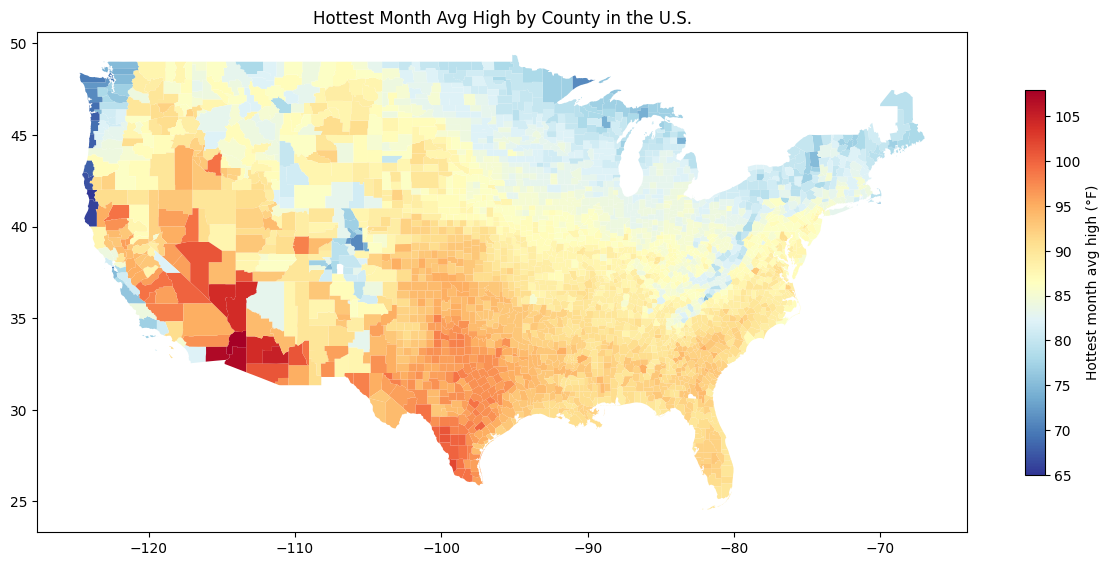

In [16]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

column = "Hottest month's avg high (F)"

# Determine the range of temperature values 
vmin = merged_data[column].min()
vmax = merged_data[column].max()
norm = Normalize(vmin=vmin, vmax=vmax)

# Use a diverging colormap such as 'RdYlBu'
cmap = 'RdYlBu_r'  # Reversed so that blue represents cooler temperatures and red represents warmer temperatures

merged_data.plot(column=column, ax=ax, cmap=cmap, norm=norm)

# Create a colorbar with the normalization
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.5)
cbar.set_label('Hottest month avg high (°F)')

plt.title('Hottest Month Avg High by County in the U.S.')
plt.show()

In [17]:
xlim = ax.get_xlim()
ylim = ax.get_ylim()
aspect_ratio = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
print(f"Aspect Ratio: {aspect_ratio}")

Aspect Ratio: 2.326251083096679


In [18]:
merged_data.to_csv("full_df.csv")